In [1]:
from FCA import *

In [55]:
fileo = open('./my_data/nws_20000nodes_1000neighbors_0.7prob/nws_20walk_graph.pkl', 'rb')
df_graph = pickle.load(fileo)
fileo.close()
df_shifted_dynamics = pd.read_csv("./my_data/nws_20000nodes_1000neighbors_0.7prob/nws_20walk_FCA_shifted_dynamics_8kappa.csv")
df_dynamics = pd.read_csv("./my_data/nws_20000nodes_1000neighbors_0.7prob/nws_20walk_FCA_dynamics_8kappa.csv")
df_features = pd.read_csv("./my_data/nws_20000nodes_1000neighbors_0.7prob/nws_20walk_graph_features.csv")
df_g2v = pd.read_csv("./my_data/nws_20000nodes_1000neighbors_0.7prob/nws_20walk_graph2vec.csv", header=None)

In [6]:
fileo = open('./my_data/UCLA26_20walk/UCLA26_20walk_graph.pkl', 'rb')
df_graph = pickle.load(fileo)
fileo.close()
df_shifted_dynamics = pd.read_csv("./my_data/UCLA26_20walk/UCLA26_20walk_FCA_shifted_dynamics_8kappa.csv")
df_dynamics = pd.read_csv("./my_data/UCLA26_20walk/UCLA26_20walk_FCA_dynamics_8kappa.csv")
df_features = pd.read_csv("./my_data/UCLA26_20walk/UCLA26_20walk_graph_features.csv")
df_g2v = pd.read_csv("./my_data/UCLA26_20walk/UCLA26_20walk_graph2vec.csv", header=None)
df_n2v = pd.read_csv("./my_data/UCLA26_20walk/UCLA26_20walk_node2vec.csv", header=None)

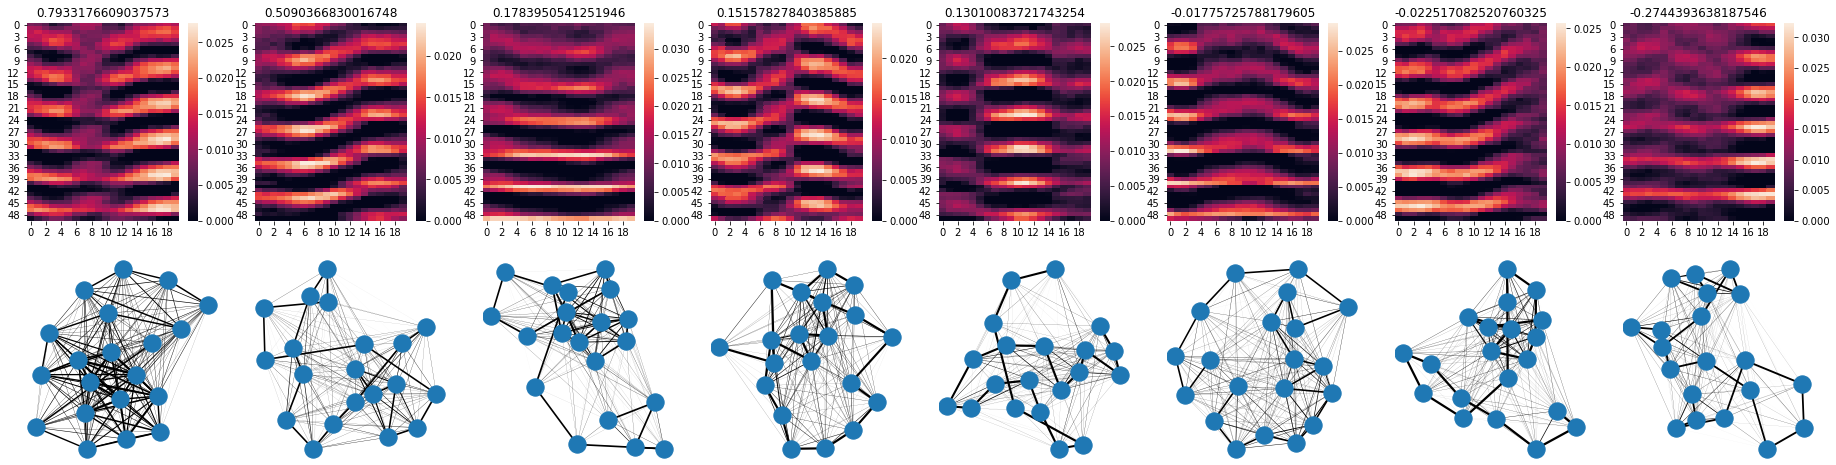

In [20]:
ncol = 8
nrow = 2
r = 8
fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(ncol*4, nrow*4))
sorted_indices = np.argsort(results_dict_new["loading"][1][0][1:])[::-1]
for i in range(r):
    ind = sorted_indices[i]
    sns.heatmap(results_dict_new["loading"][0].T[ind][0:1000].reshape(50, 20),
                ax = axs[i//ncol, (i-4)%ncol])
    axs[i//ncol, i%ncol].title.set_text(str(results_dict_new["loading"][1][0][1:][sorted_indices[i]]))
    
    df_adj = pd.DataFrame(results_dict_new["loading"][0].T[ind][1000:].reshape(20, 20))
    G = nx.Graph()
    G = nx.from_pandas_adjacency(df_adj)
    edges = G.edges()
    weights = [120*G[u][v]['weight'] for u,v in edges]
    nx.draw(G, ax=axs[i//ncol+1, i%ncol], width=weights)

## Baseline

In [56]:
df = df_dynamics.copy()
Y_data = df_dynamics.y #concentration
df.drop('y', axis=1, inplace=True)

under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(df, Y_data)
Y_baseline = X_res.baseline_width
Y_data = y_res

#baseline model
length = len(Y_baseline[Y_baseline==False])
Y_baseline[random.sample(list(Y_baseline[Y_baseline==False].index),length//2)] = True
conf_matrix_baseline = confusion_matrix(y_true=Y_data, y_pred=Y_baseline)
print(conf_matrix_baseline)
print('Precision: %.3f' % precision_score(Y_data, Y_baseline))
print('Recall: %.3f' % recall_score(Y_data, Y_baseline))
print('F1: %.3f' % f1_score(Y_data, Y_baseline))
print('Accuracy: %.3f' % accuracy_score(Y_data, Y_baseline))
acc_baseline = accuracy_score(Y_data, Y_baseline)

[[1243 1209]
 [ 306 2146]]
Precision: 0.640
Recall: 0.875
F1: 0.739
Accuracy: 0.691


## 1. Dynamics

In [57]:
df = df_dynamics.loc[:, 's1_1':'s50_20'].copy()
Y_data = df_dynamics.y
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(df, Y_data)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                                    test_size = 0.2, 
                                                    random_state = 4, 
                                                    stratify = y_res)


rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
conf_matrix_dynamics = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(conf_matrix_dynamics)
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
acc_dynamics = accuracy_score(y_test, y_pred)

[[481  10]
 [164 326]]
Precision: 0.970
Recall: 0.665
F1: 0.789
Accuracy: 0.823


## 2. Summarized Dynamics

In [58]:
df = df_dynamics.loc[:, 'q1_s1':'width_s50'].copy()
Y_data = df_dynamics.y
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(df, Y_data)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                                    test_size = 0.2, 
                                                    random_state = 4, 
                                                    stratify = y_res)


rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
conf_matrix_summarized_dynamics = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(conf_matrix_summarized_dynamics)
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
acc_summarized_dynamics = accuracy_score(y_test, y_pred)

[[490   1]
 [ 87 403]]
Precision: 0.998
Recall: 0.822
F1: 0.902
Accuracy: 0.910


## 3. Shifted Dynamics

In [59]:
df = df_shifted_dynamics.copy()
Y_data = df_dynamics.y
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(df, Y_data)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                                    test_size = 0.2, 
                                                    random_state = 4, 
                                                    stratify = y_res)


rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
conf_matrix_shifted_dynamics = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(conf_matrix_shifted_dynamics)
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
acc_shifted_dynamics = accuracy_score(y_test, y_pred)

[[490   1]
 [153 337]]
Precision: 0.997
Recall: 0.688
F1: 0.814
Accuracy: 0.843


## 4. Graph Features + Dynamics

In [68]:
df = pd.concat([df_dynamics.loc[:, 's1_1':'s50_20'], 
                df_features], axis=1, join='inner').copy()
Y_data = df_dynamics.y
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(df, Y_data)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                                    test_size = 0.2, 
                                                    random_state = 4, 
                                                    stratify = y_res)
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
conf_matrix_features = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(conf_matrix_features)
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
acc_features = accuracy_score(y_test, y_pred)

[[474  17]
 [164 326]]
Precision: 0.950
Recall: 0.665
F1: 0.783
Accuracy: 0.815


## 5. node2vec + Dynamics

In [61]:
df = pd.concat([df_dynamics.loc[:, 's1_1':'s50_20'], 
                df_n2v], axis=1, join='inner').copy()
Y_data = df_dynamics.y
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(df, Y_data)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                                    test_size = 0.2, 
                                                    random_state = 4, 
                                                    stratify = y_res)
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
conf_matrix_n2v = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(conf_matrix_n2v)
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
acc_n2v = accuracy_score(y_test, y_pred)

[[475  16]
 [179 311]]
Precision: 0.951
Recall: 0.635
F1: 0.761
Accuracy: 0.801


## 6. graph2vec + Dynamics

In [62]:
df = pd.concat([df_dynamics.loc[:, 's1_1':'s50_20'], 
                df_g2v], axis=1, join='inner').copy()
Y_data = df_dynamics.y
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(df, Y_data)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                                    test_size = 0.2, 
                                                    random_state = 4, 
                                                    stratify = y_res)
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
conf_matrix_g2v = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(conf_matrix_g2v)
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
acc_g2v = accuracy_score(y_test, y_pred)

[[477  14]
 [170 320]]
Precision: 0.958
Recall: 0.653
F1: 0.777
Accuracy: 0.812


## 7. adjacency matrix + Dynamics

In [63]:
df = pd.concat([df_dynamics.loc[:, 's1_1':'s50_20'], 
                pd.DataFrame(df_graph.T)], axis=1, join='inner').copy()
Y_data = df_dynamics.y
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(df, Y_data)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                                    test_size = 0.2, 
                                                    random_state = 4, 
                                                    stratify = y_res)
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
conf_matrix_adj = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(conf_matrix_adj)
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
acc_adj = accuracy_score(y_test, y_pred)

[[482   9]
 [180 310]]
Precision: 0.972
Recall: 0.633
F1: 0.766
Accuracy: 0.807


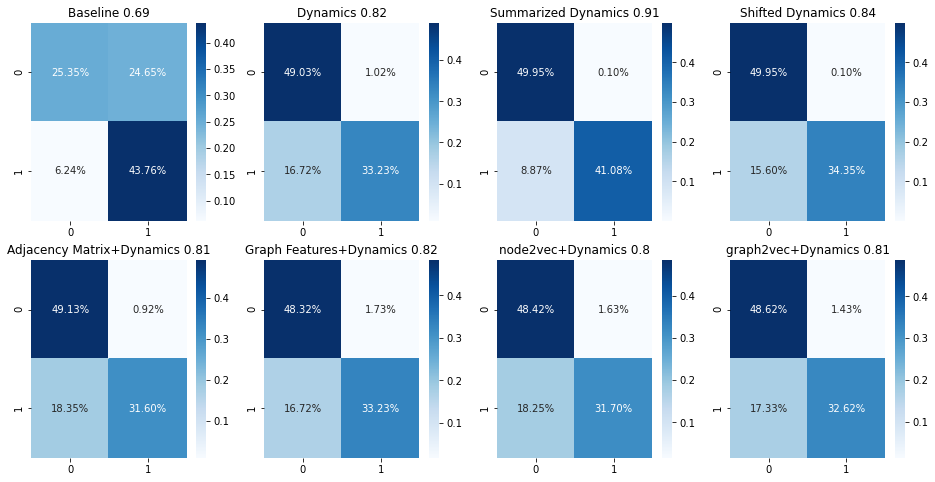

In [64]:
ncol = 4
nrow = 2
fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(ncol*4, nrow*4))
sns.heatmap(conf_matrix_baseline/np.sum(conf_matrix_baseline), annot=True, 
            fmt='.2%', cmap='Blues', ax = axs[0, 0])
axs[0, 0].title.set_text('Baseline '+str(round(acc_baseline, 2)))

sns.heatmap(conf_matrix_dynamics/np.sum(conf_matrix_dynamics), annot=True, 
            fmt='.2%', cmap='Blues', ax = axs[0, 1])
axs[0, 1].title.set_text('Dynamics '+str(round(acc_dynamics, 2)))
sns.heatmap(conf_matrix_summarized_dynamics/np.sum(conf_matrix_summarized_dynamics), annot=True, 
            fmt='.2%', cmap='Blues', ax = axs[0, 2])
axs[0, 2].title.set_text('Summarized Dynamics '+str(round(acc_summarized_dynamics, 2)))
sns.heatmap(conf_matrix_shifted_dynamics/np.sum(conf_matrix_shifted_dynamics), annot=True, 
            fmt='.2%', cmap='Blues', ax = axs[0, 3])
axs[0, 3].title.set_text('Shifted Dynamics '+str(round(acc_shifted_dynamics, 2)))

sns.heatmap(conf_matrix_adj/np.sum(conf_matrix_adj), annot=True, 
            fmt='.2%', cmap='Blues', ax = axs[1, 0])
axs[1, 0].title.set_text('Adjacency Matrix+Dynamics '+str(round(acc_adj, 2)))
sns.heatmap(conf_matrix_features/np.sum(conf_matrix_features), annot=True, 
            fmt='.2%', cmap='Blues', ax = axs[1, 1])
axs[1, 1].title.set_text('Graph Features+Dynamics '+str(round(acc_features, 2)))
sns.heatmap(conf_matrix_n2v/np.sum(conf_matrix_n2v), annot=True, 
            fmt='.2%', cmap='Blues', ax = axs[1, 2])
axs[1, 2].title.set_text('node2vec+Dynamics '+str(round(acc_n2v, 2)))
sns.heatmap(conf_matrix_g2v/np.sum(conf_matrix_g2v), annot=True, 
            fmt='.2%', cmap='Blues', ax = axs[1, 3])
axs[1, 3].title.set_text('graph2vec+Dynamics '+str(round(acc_g2v, 2)))

fig.savefig("temp.jpg")

### better display of confusion matrix

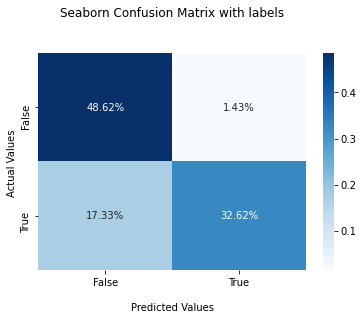

In [66]:
cf_matrix = conf_matrix_g2v
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

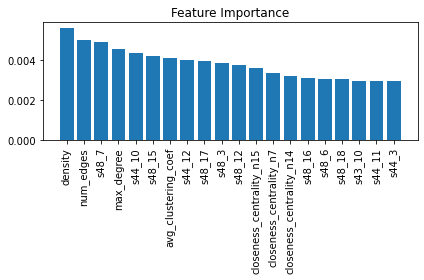

In [69]:
importances = rf.feature_importances_

sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance')
plt.bar(range(20), list(importances[sorted_indices])[0:20], align='center')
plt.xticks(range(20), list(X_train.columns[sorted_indices])[0:20], rotation=90)
plt.tight_layout()
plt.show()

In [26]:
for i in list(X_train.columns[sorted_indices])[0:50]:
    if not i.count('width'):
        print(i)
        
plt.figure(figsize=(16,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    colname = "closeness_centrality_n"+str(i+1)
    plt.hist(df_features[colname][Y_data==True], color = "skyblue",  lw=0)
    plt.hist(df_features[colname][Y_data==False], color = "red", lw=0)
    plt.title("Node"+str(i+1))

closeness_centrality_n20
closeness_centrality_n19
diameter
closeness_centrality_n18
closeness_centrality_n17
closeness_centrality_n3
closeness_centrality_n2
closeness_centrality_n5
closeness_centrality_n1
betweenness_centrality_n14
closeness_centrality_n4
closeness_centrality_n6
betweenness_centrality_n10
betweenness_centrality_n9
betweenness_centrality_n11
eigenvector_centrality_n20
betweenness_centrality_n8
avg_clustering_coef
eigenvector_centrality_n1
eigenvector_centrality_n2
closeness_centrality_n14
eigenvector_centrality_n4
eigenvector_centrality_n3
closeness_centrality_n15
betweenness_centrality_n15
closeness_centrality_n16
closeness_centrality_n10
closeness_centrality_n9


In [ ]:
"""
svc = SVC(kernel='linear', C=10.0, random_state=1)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(conf_matrix)
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
"""


"""
 # xgboost for feature importance on a classification problem
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
# define the model
model = XGBClassifier()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print("Feature: ", df.columns[i], ", Score: %.5f" % (v))
"""


#fig, ax = plt.subplots(figsize=(5, 5))
#ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
#for i in range(conf_matrix.shape[0]):
#    for j in range(conf_matrix.shape[1]):
#        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')